In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from datetime import datetime, timedelta
import os

from pyspark.sql.functions import coalesce, lit, rand, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pyspark.sql.utils

In [ ]:
packages = [
    'org.apache.hadoop:hadoop-aws:3.3.4',
    'org.apache.hadoop:hadoop-client-api:3.3.4',
    'org.apache.hadoop:hadoop-client-runtime:3.3.4',
    'io.delta:delta-core_2.12:2.4.0',
]

conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set('spark.jars.packages', ','.join(packages)) \
    .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .set("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .set("spark.databricks.delta.retentionDurationCheck.enabled", "false")

sc = SparkContext(conf=conf)

hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_config.set('com.amazonaws.services.s3.enableV4', 'true')

spark = SparkSession(sc)

In [3]:
class LogisticRegressionTrial:

    def __init__(self, data, save_path, seed, num_partitions=200):
        self.data = data
        self.save_path = save_path
        self.seed = seed

        # 今はどこでも使ってない
        self.num_partitions = num_partitions
        
        self.train_data = None
        self.test_data = None

        self.pipeline_model_path = os.path.join(self.save_path, "pipeline")
        self.lr_model_path = os.path.join(self.save_path, "model")
        self.coeff_path = os.path.join(self.save_path, "coeff")
        self.prediction_path = os.path.join(self.save_path, "prediction")
        self.evaluation_path = os.path.join(self.save_path, "evalation")
    
    def _split_data(self):
        # Split the data into training and test sets (80% training, 20% test)
        self.train_data, self.test_data = data.randomSplit([0.8, 0.2], self.seed)

    def init(self):
        if not self.train_data or not self.test_data:
            self._split_data()
        
        # String Indexing for features
        self.indexers = [
            StringIndexer(inputCol="label", outputCol="label_index"),
            StringIndexer(inputCol="color", outputCol="color_index"),
            StringIndexer(inputCol="type", outputCol="type_index"),
            StringIndexer(inputCol="localHour", outputCol="localHour_index"),
            StringIndexer(inputCol="dayOfWeek", outputCol="dayOfWeek_index"),
        ]
        
        # One-Hot Encoding for Logistic Regression (not needed for tree-based models)
        self.encoder = OneHotEncoder(
            inputCols=["color_index", "type_index", "localHour_index", "dayOfWeek_index"],
            outputCols=["color_vec", "type_vec", "localHour_vec", "dayOfWeek_vec"]
        )

        self.assembler_lr_nb = VectorAssembler(
            inputCols=["type_vec", "color_vec", "localHour_vec", "milesperhour", "age", "dayOfWeek_vec"],
            outputCol="assembled_features"
        )
    
        # MinMaxScaler for Logistic Regression and Naive Bayes
        self.scaler_lr_nb = MinMaxScaler(inputCol="assembled_features", outputCol="features")
        
        # Create and Fit the Pipeline for Logistic Regression and Naive Bayes
        self.pipeline_lr_nb = Pipeline(stages=self.indexers + [self.encoder, self.assembler_lr_nb, self.scaler_lr_nb])
        self.model_lr_nb = self.pipeline_lr_nb.fit(self.train_data)
        self.transformed_train_data_lr_nb = self.model_lr_nb.transform(self.train_data)
        self.transformed_test_data_lr_nb = self.model_lr_nb.transform(self.test_data)

        self.lr = LogisticRegression(featuresCol="features", labelCol="label_index")
        self.lr_model = None
    
    def get_labels(self):
        return self.model_lr_nb.stages[0].labels

    def get_features(self):
        if 'assembled_features' in self.transformed_train_data_lr_nb.schema.names:
            feature_attrs = self.transformed_train_data_lr_nb.schema['assembled_features'].metadata['ml_attr']['attrs']
        else:
            feature_attrs = self.transformed_train_data_lr_nb.schema['features'].metadata['ml_attr']['attrs']
    
        features = []
        for attr_type, attrs in feature_attrs.items():
            features += attrs
    
        # for each in sorted(features, key=lambda x: x['idx']):
        #     print(each['idx'], each['name'])
        
        feature_names = [each['name'] for each in sorted(features, key=lambda x: x['idx'])]
    
        return feature_names

    def run(self):
        # Training the Logistic Regression Model
        self.lr_model = self.lr.fit(self.transformed_train_data_lr_nb)

        # Get model coefficients and intercept for Logistic Regression
        coefficients = self.lr_model.coefficientMatrix
        intercept = self.lr_model.interceptVector
        # print(f"Coefficients: {coefficients}")
        # print(f"Intercept: {intercept}")

        coef_df = pd.DataFrame(
            np.array(coefficients.toArray().tolist()),
            columns=self.get_features()
        )
        
        coef_df['label'] = self.get_labels()
        coef_df[['label'] + list(coef_df.columns)[:-1]].sort_values(by="label")
        coef_df2 = coef_df.reset_index(drop=True).melt(id_vars=['label'], var_name='feature', value_name='coefficient')
        coef_df2[['label', 'feature', 'coefficient']].sort_values(by=['label', 'feature'])
        coeff_pd_df = coef_df2.rename(columns={"feature": "Feature", "coefficient": "Coefficient"})

        local_hour_mappings = {f"localHour_vec_{i}": f"localHour_vec_{i:02d}" for i in range(1, 24)}
        days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
        day_of_week_mappingss = {f"dayOfWeek_vec_{day}": f"dayOfWeek_vec_{i}{day}" for i, day in enumerate(days_of_week)}
        feature_mappings = {**local_hour_mappings, **day_of_week_mappingss}
        
        # # Get unique sorted columb values
        unique_columnb_values = sorted(coeff_pd_df['label'].unique())
        
        # Create a dictionary to hold the data for the new
        data_dict = {'Feature': []}
        for b_value in unique_columnb_values:
            data_dict[f'label_{b_value}'] = []
        
        # Populate the dictionary
        unique_columna_values = coeff_pd_df['Feature'].unique()
        for a_value in unique_columna_values:
            data_dict['Feature'].append(a_value)
            for b_value in unique_columnb_values:
                if a_value in coeff_pd_df[coeff_pd_df['label'] == b_value]['Feature'].values:
                    data_dict[f'label_{b_value}'].append(coeff_pd_df[(coeff_pd_df['label'] == b_value) & (coeff_pd_df['Feature'] == a_value)]['Coefficient'].values[0])
                else:
                    data_dict[f'label_{b_value}'].append(None)
        
        # Create the new DataFrame
        top5_df = pd.DataFrame(data_dict)
        
        top5_df['Feature_alias'] = top5_df.Feature.apply(lambda feature_name: feature_mappings.get(feature_name, feature_name))
        
        # Display the DataFrame
        top5_df.sort_values(by="Feature_alias").drop(columns=["Feature_alias"])

        self.coeff_df = spark.createDataFrame(top5_df)

        # Initialize evaluators for all models
        evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="accuracy")
        evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedPrecision")
        evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedRecall")
        evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="f1")
        
        # Evaluating the Logistic Regression Model
        self.lr_predictions = trial.lr_model.transform(trial.transformed_test_data_lr_nb)
        self.evaluation = spark.createDataFrame(pd.DataFrame({
            'accuracy': [evaluator_accuracy.evaluate(self.lr_predictions)],
            'precision': [evaluator_precision.evaluate(self.lr_predictions)],
            'recall': [evaluator_recall.evaluate(self.lr_predictions)],
            'f1': [evaluator_f1.evaluate(self.lr_predictions)],
        }))
    
    def save_models(self):        
        self.model_lr_nb.write().overwrite().save(self.pipeline_model_path)
        self.lr_model.write().overwrite().save(self.lr_model_path)
        self.coeff_df.write.format("delta").mode("overwrite").save(self.coeff_path)
        self.lr_predictions.write.format("delta").mode("overwrite").save(self.prediction_path)
        self.evaluation.write.format("delta").mode("overwrite").save(self.evaluation_path)

    def load_models(self):
        self.model_lr_nb =  PipelineModel.load(self.pipeline_model_path)
        self.lr_model = LogisticRegressionModel.load(self.lr_model_path)
        self.coeff_df = spark.read.load(self.coeff_path)
        self.lr_predictions = spark.read.load(self.prediction_path)
        self.evaluation = spark.read.load(self.evaluation_path)

    def transform(self):
        # load_models したあとに train, test も必要になったとき用
        if not self.train_data or not self.test_data:
            self._split_data()
        self.transformed_train_data_lr_nb = self.model_lr_nb.transform(self.train_data)
        self.transformed_test_data_lr_nb = self.model_lr_nb.transform(self.test_data)

In [6]:
from pyspark.sql import Row
from pyspark.sql.types import *

# Define the possible values for each column
colors = ["red", "blue", "green"]
types = ["SUV", "sedan", "truck"]
labels = ["class1", "class2", "class3"]
days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Generate random data
data = []
for i in range(1000):
    id_val = i
    color_val = random.choice(colors)
    type_val = random.choice(types)
    localHour_val = random.randint(0, 23)
    milesperhour_val = round(random.uniform(15.0, 35.0), 1)
    age_val = random.randint(18, 80)
    label_val = random.choice(labels)
    date_val = f"2024-07-{random.randint(1, 31):02d}"
    geohash_val = f"u4pruydqqv{random.choice('abcdefghijklmnopqrstuvwxyz')}"
    dayOfWeek_val = random.choice(days_of_week)
    
    row = Row(id=id_val, color=color_val, type=type_val, localHour=localHour_val, milesperhour=milesperhour_val, age=age_val, label=label_val, date=date_val, geohash=geohash_val, dayOfWeek=dayOfWeek_val)
    data.append(row)

# Create DataFrame
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("color", StringType(), False),
    StructField("type", StringType(), False),
    StructField("localHour", IntegerType(), False),
    StructField("milesperhour", FloatType(), False),
    StructField("age", IntegerType(), False),
    StructField("label", StringType(), False),
    StructField("date", StringType(), False),
    StructField("geohash", StringType(), False),
    StructField("dayOfWeek", StringType(), False)
])

data = spark.createDataFrame(data, schema)

# seedを変えながら複数回モデルを回して coeff 等を保存

In [8]:
from py4j.java_gateway import Py4JJavaError
import pyspark.sql.utils

# string label
# data = spark.createDataFrame([
#     (0, "red",   "SUV",   12, 20.0, 60, "class1", "2024-07-01", "u4pruydqqvj", "Sunday"),
#     (1, "red",   "sedan",  9, 30.0, 70, "class2", "2024-07-02", "u4pruydqqvk", "Friday"),
#     (2, "red",   "truck", 15, 25.0, 80, "class3", "2024-07-01", "u4pruydqqvj", "Sunday"),
#     (3, "blue",  "SUV",   20, 22.0, 65, "class1", "2024-07-02", "u4pruydqqvk", "Monday"),
#     (4, "blue",  "sedan",  5, 35.0, 75, "class1", "2024-07-01", "u4pruydqqvj", "Tuesday"),
#     (5, "blue",  "truck", 12, 28.0, 85, "class3", "2024-07-02", "u4pruydqqvk", "Tuesday"),
#     (6, "green", "SUV",    9, 19.0, 50, "class2", "2024-07-03", "u4pruydqqvl", "Sunday"),
#     (7, "green", "sedan", 15, 32.0, 60, "class3", "2024-07-03", "u4pruydqqvm", "Thursday"),
#     (8, "green", "truck", 20, 27.0, 40, "class1", "2024-07-04", "u4pruydqqvn", "Saturday"),
#     (9, "green", "SUV",    5, 21.0, 55, "class2", "2024-07-04", "u4pruydqqvo", "Saturday")
# ], ["id", "color", "type", "localHour", "milesperhour", "age", "label", "date", "geohash", "dayOfWeek"])

num_trials = 5
path_prefix = "coeff_comp4"

for trial_number in range(num_trials):
    save_path = os.path.join(path_prefix, str(trial_number))
    trial = LogisticRegressionTrial(data=data, save_path=save_path, num_partitions=1, seed=trial_number)
    try:
        print(f"loading {trial_number=}")
        trial.load_models()
        print(f"{trial_number=} already exists")
        continue
    except (pyspark.sql.utils.AnalysisException, Py4JJavaError) as e:
        print("model not found")
        trial.init()
        trial.run()
        trial.save_models()

loading trial_number=0
model not found
loading trial_number=1
model not found
loading trial_number=2
model not found
loading trial_number=3
model not found
loading trial_number=4
model not found


# 結果のロード

In [23]:
# trial ごとの結果を pandas DataFrame としてロードする
coeff_dfs = []  # pandas dataframe
pred_dfs = []  # pyspark dataframe
eval_dfs = []  # pandas dataframe
for trial_number in range(num_trials):
    save_path = os.path.join(path_prefix, str(trial_number))
    trial = LogisticRegressionTrial(data=data, save_path=save_path, num_partitions=1, seed=trial_number)
    trial.load_models()
    coeff_dfs.append(trial.coeff_df.toPandas())
    pred_dfs.append(trial.lr_predictions)
    eval_dfs.append(trial.evaluation.toPandas())

## coeff の比較

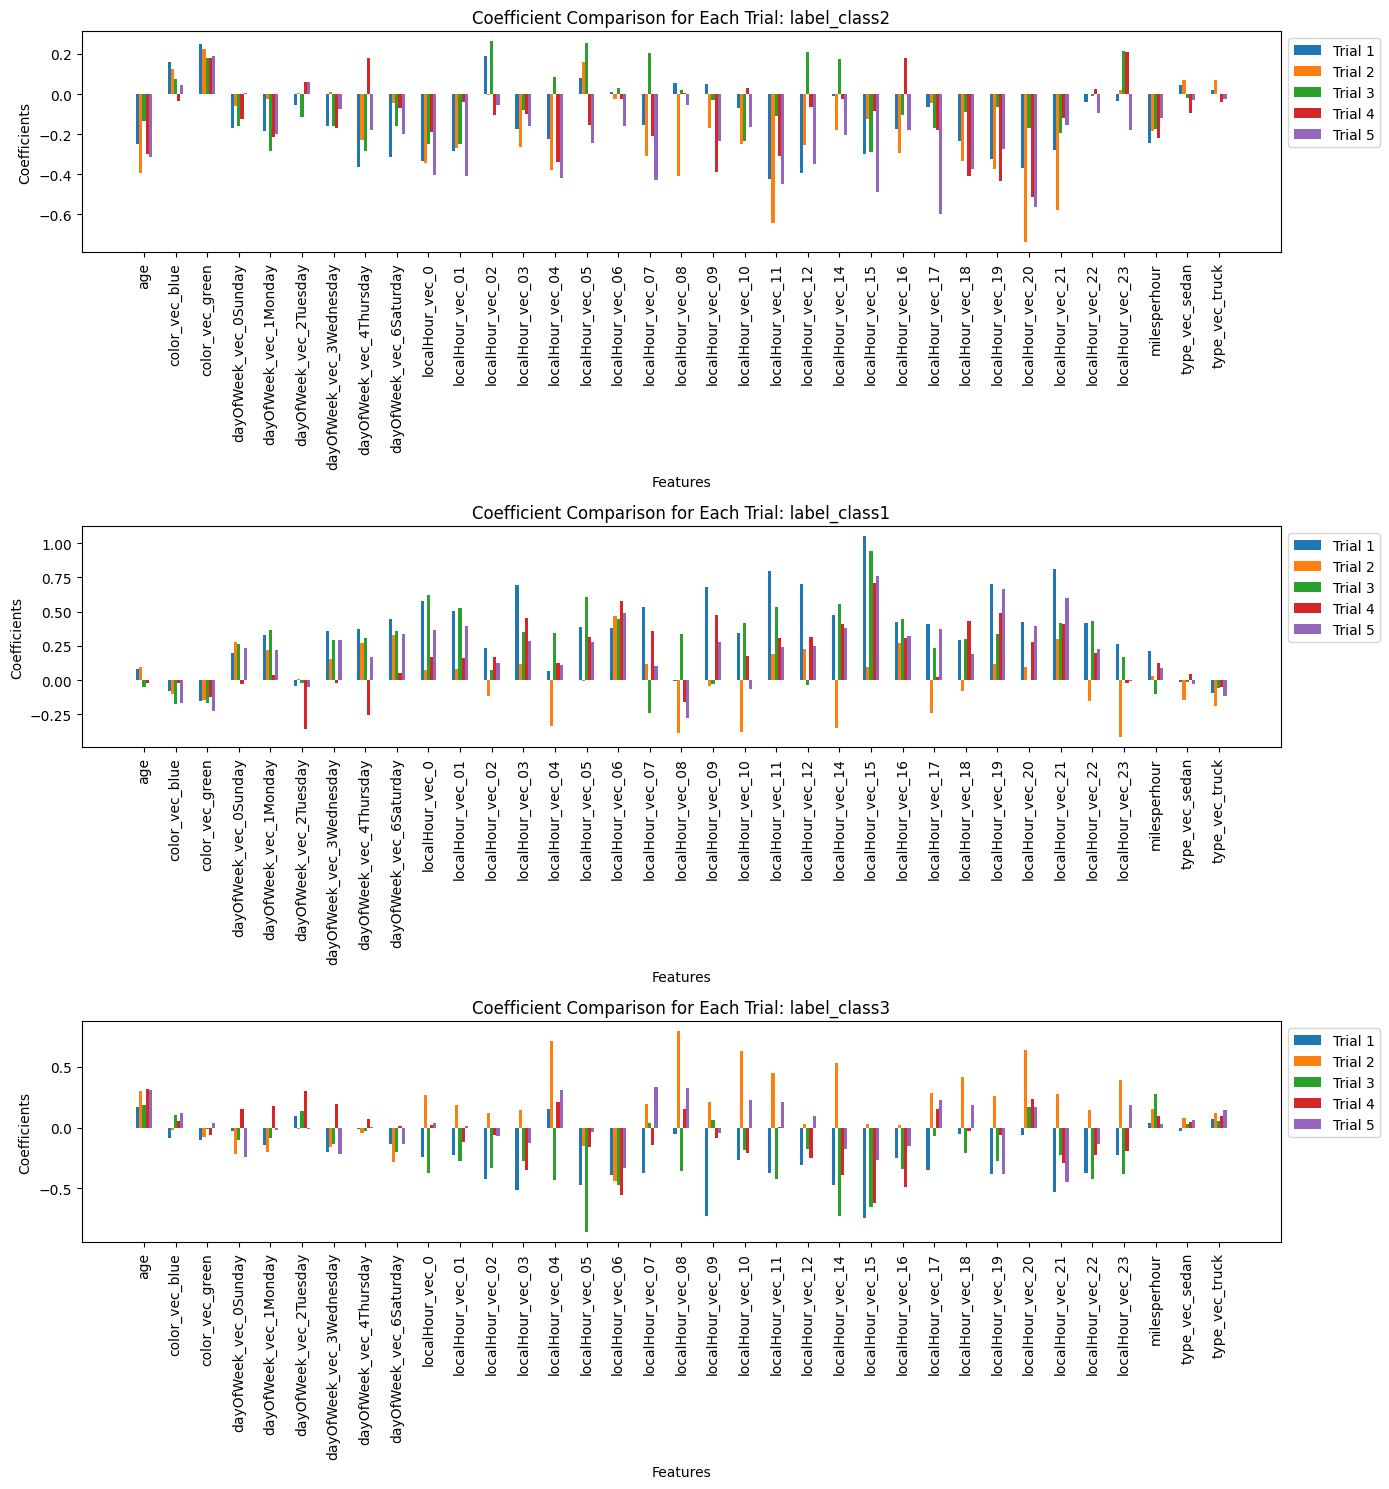

In [18]:
labels = [f"label_{each.label}" for each in data.select(col("label")).distinct().collect()]

# Create a figure with subplots
fig, axes = plt.subplots(len(labels), 1, figsize=(14, len(labels) * 5))

# Plot each label's coefficients
for idx, label in enumerate(labels):
    ax = axes[idx]
    for i, df in enumerate(coeff_dfs):
        width = 0.1  # Width of the bars
        x = range(len(df))  # X locations for the groups
        ax.bar([p + width*i for p in x], df.sort_values(by="Feature_alias")[label], width=width, label=f'Trial {i+1}')
    
    # Add titles and labels
    ax.set_title(f'Coefficient Comparison for Each Trial: {label}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Coefficients')
    ax.set_xticks([p + width*(len(coeff_dfs)/2 - 0.5) for p in x])

    ax.set_xticklabels(df.sort_values(by="Feature_alias")['Feature_alias'], rotation=90)

    # set xtickslabels only on the last plot
    # if idx < len(labels) - 1:
    #     ax.set_xticklabels([])
    # else:
    #     ax.set_xticklabels(df['Feature_alias'], rotation=90)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('coefficients_comparison.png')

# evaluation

In [24]:
eval_dfs[0]

,accuracy,precision,recall,f1
0,0.321782,0.330756,0.321782,0.316401


In [32]:
eval_dfs[0].to_numpy()

array([[0.32178218, 0.33075629, 0.32178218, 0.31640121]])

In [52]:
metrics = eval_dfs[0].columns
eval_dfs_combined = pd.DataFrame([each.to_numpy()[0] for each in eval_dfs], columns=metrics)
# eval_dfs_combined = eval_dfs_combined.reset_index().rename(columns={"index": "trial"})

In [56]:
index

Index(['accuracy', 'precision', 'recall', 'f1'], dtype='object')

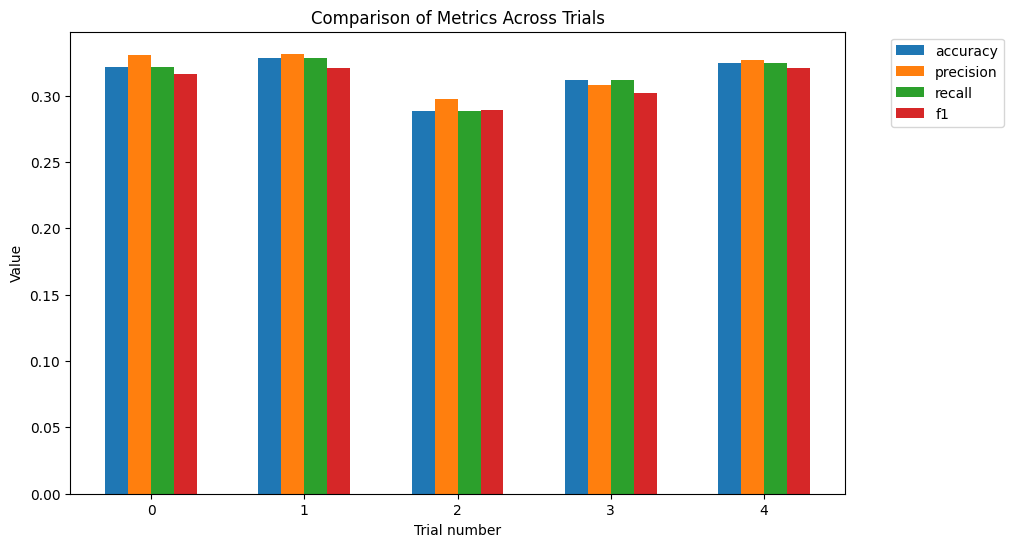

In [50]:
num_metrics = len(metrics)
fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(eval_dfs_combined['trial'] + i*0.15, eval_dfs_combined[metric], width=0.15, label=metric)

ax.set_xlabel('Trial number')
ax.set_ylabel('Value')
ax.set_title('Comparison of Metrics Across Trials')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(eval_dfs_combined['trial'] + 0.15 * (num_metrics - 1) / 2, eval_dfs_combined['trial'])
plt.show()

## predictions

In [20]:
pred_dfs[0].show(1)

+---+-----+-----+---------+------------+---+------+----------+-----------+---------+-----------+-----------+----------+---------------+---------------+---------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|color| type|localHour|milesperhour|age| label|      date|    geohash|dayOfWeek|label_index|color_index|type_index|localHour_index|dayOfWeek_index|color_vec|     type_vec|localHour_vec|dayOfWeek_vec|  assembled_features|            features|       rawPrediction|         probability|prediction|
+---+-----+-----+---------+------------+---+------+----------+-----------+---------+-----------+-----------+----------+---------------+---------------+---------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
|880|  red|sedan|       13|        32.1| 31|class3|2024-07-18|u4pruydqqvp|   Sunday|        2.0|       